In [1]:
import pandas.io.sql as psql
import json
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
#from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit import rdBase
from rdkit import DataStructs
#import psycopg2 as pg


import pandas as pd
import sqlalchemy as db
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine
from pandas import concat

from collections import OrderedDict
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split

import cheminformatics.utils.multicore as multicore
import time
import math
from multiprocessing import Pool,Queue, Process, cpu_count
import os
import sys

import chemfp
from chemfp import search

import numpy as np

import random
from numpy import median 
from itertools import combinations

from rdkit.Chem import QED 

# read core info

In [2]:
pool = pd.read_csv("../03_target_pred/Results/query_with_targets.csv",encoding='utf-8')

In [3]:
print(pool.shape)
pool.head()

(1448145, 3)


query_index                   query_smiles                  targets
0         9812   C1CCCC(N2CCN(C3CCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
1        13121   C1CCC(N2CCN(C3CCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
2         9438  C1CCCC(N2CCC(N3CCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
3        12848   C1CCC(N2CCC(N3CCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}
4        12853  C1CCC(N2CCC(N3CCCCCC3)CC2)CC1  {CHEMBL4153,CHEMBL5525}

In [4]:
targets_novelty_scores = pd.read_csv("../01_chembl_data_prep/Results/targets_with_novelty_scores.csv",encoding='utf-8')

In [5]:
targets_novelty_scores.head()

target_chembl_id   clan     pfam  clan_novelty_score  pfam_novelty_score  \
0    CHEMBL1075021   c519  PF00204            0.880137            0.813719   
1    CHEMBL1075022   c637  PF00204            0.166667            0.813719   
2    CHEMBL1075023  c1484  PF01048            0.000000            0.269437   
3    CHEMBL1075024   c582  PF03060            0.250000            0.250000   
4    CHEMBL1075025  c1864  PF01255            0.000000            0.000000   

   in_actives  in_predicted  
0           1             0  
1           1             0  
2           1             1  
3           1             1  
4           1             1

In [6]:
clusters = pd.read_csv("../02_zinc15_data_prep/Results/parsed_clusers_04.csv")
clusters['cluster_id'] = np.where((clusters.cluster_id == 'false_singleton'),clusters.member,clusters.member)
clusters.head()

/Home/ii/neannm/anaconda3/envs/rdkit3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


cluster_id   member
0     1000192  1000192
1     1000844  1000844
2     1001115  1001115
3     1001430  1001430
4     1001929  1001929

# novel7_elitist_pfam_novelty_parallel_10k_500_300_0randoms - not using and still running

## fitness score evolution

In [7]:
evolution_scores = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_10k_500_300_0randoms/result_novel7_elitist_pfam_novelty_parallel_10k_500_300_0randoms.csv",encoding='utf-8')

In [8]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [9]:
print(evolution_scores.shape)
evolution_scores.head()

(62500, 3)


fitness  generation   use
0  0.435294           0  True
1  0.425805           0  True
2  0.432348           0  True
3  0.432532           0  True
4  0.434287           0  True

In [10]:
evolution_scores.tail()

fitness  generation    use
62495  0.501528         124  False
62496  0.510549         124  False
62497  0.504542         124  False
62498  0.498302         124  False
62499  0.499614         124  False

In [11]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.435294           0  True
1  0.425805           0  True
2  0.432348           0  True
3  0.432532           0  True
4  0.434287           0  True

Text(0, 0.5, 'fitness')

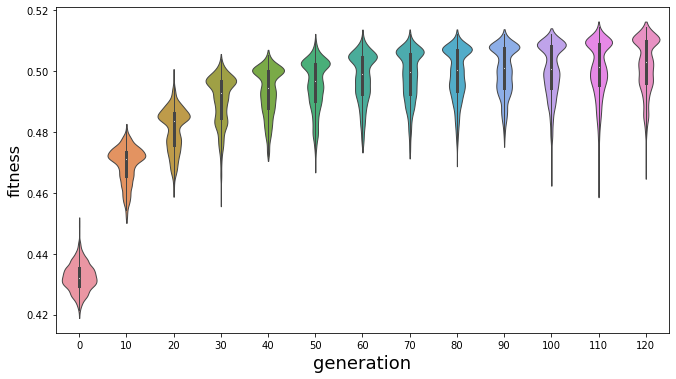

In [12]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


In [13]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation   fitness    use
0           0  0.451040   True
1           1  0.455339  False
2           2  0.459731  False
3           3  0.463899  False
4           4  0.469230  False

<AxesSubplot:xlabel='generation', ylabel='fitness'>

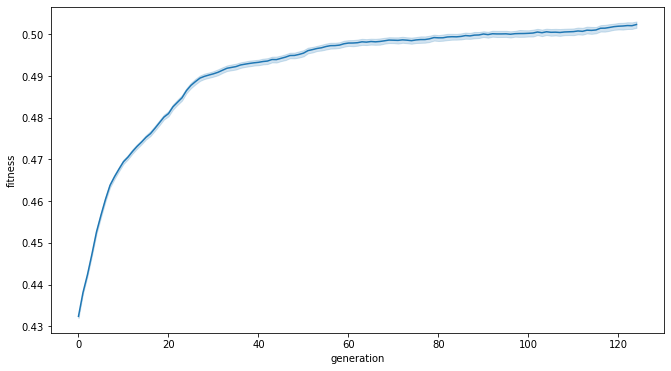

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

Text(0, 0.5, 'fitness')

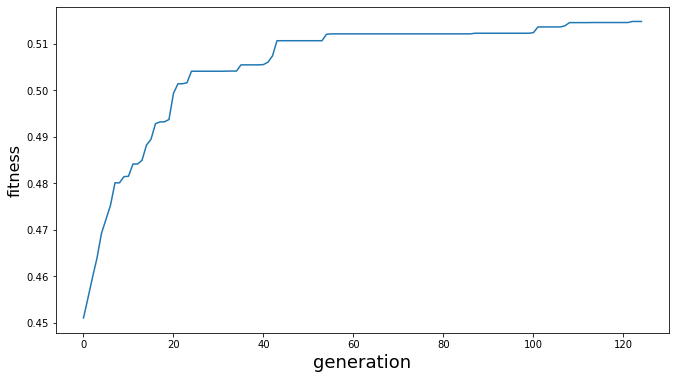

In [15]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)

In [16]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 0.451039802167369
max overall: 0.5147858893638156
improvement: 14.13314011094572


## population scaffold change

In [17]:
best_pop_at_0 = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_10k_500_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_10k_500_300_0randoms_0.csv",encoding='utf-8',names=['file_index'])

In [18]:
best_pop_overall = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_10k_500_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_10k_500_300_0randoms_191.csv",encoding='utf-8',names=['file_index'])

In [19]:
print(len(best_pop_at_0))
print(len(best_pop_overall))

10000
10000


In [20]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  query_index                                       query_smiles  \
0    526662.0        33472                 Cc1c(Br)cnn1[C@H](C)C(=O)NCc1ccco1   
1    144585.0      2475681                        O=C1COc2ccccc2N1Cc1ccccc1Cl   
2    405163.0       309300  CC1(C)CC(NC(=O)[C@@]23C[C@@H]4CC[C@]2(C)[C@]4(...   
3    739131.0       622827               Cc1nn(C)c(C)c1CNc1ccc2c(c1)CCC(=O)N2   
4    428513.0      1302433  CCOc1cc(/C=C2\C(=O)NC(=O)N(c3ccc(Br)cc3)C2=O)c...   

           targets  
0  {CHEMBL1293232}  
1  {CHEMBL1293303}  
2     {CHEMBL3622}  
3  {CHEMBL3988596}  
4     {CHEMBL6136}

In [21]:
best_pop_overall = pd.merge(best_pop_overall, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_overall.head()

file_index  query_index                                      query_smiles  \
0    983046.0      1289147         CCNC(=O)CN(c1ccc(Br)cc1)S(=O)(=O)c1ccccc1   
1    753670.0      1168676  C[C@@H](NC(=O)CCN1CCC2(CC1)C(=O)NCCCN2C)c1ccccc1   
2    851979.0       830605                      CCCCC(=O)Nc1nnc(Cc2ccccc2)s1   
3    524301.0       494859            Cc1cnn(-c2cc(N/N=C/c3cccc(F)c3)ncn2)c1   
4   1343502.0      1790024    COc1ccc2c(c1)CCN(S(=O)(=O)c1ccc(C)cc1)C[C@H]2O   

                                       targets  
0                              {CHEMBL1293248}  
1                                 {CHEMBL2335}  
2                              {CHEMBL1287622}  
3                                 {CHEMBL3356}  
4  {CHEMBL205,CHEMBL261,CHEMBL3594,CHEMBL3510}

In [22]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [23]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_overall,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_overall, molCol='molecule', MurckoCol='murcko_smiles')

In [24]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()
max_overall = best_pop_overall['murcko_smiles'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 7612
max overall: 7662
% improvement: 0.6568575932737782
 improvement: 50


## cluster representation change

In [25]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")
best_pop_overall = pd.merge(best_pop_overall, clusters,  how = 'left', left_on="query_index", right_on="member")

file_index  query_index                                       query_smiles  \
0    526662.0        33472                 Cc1c(Br)cnn1[C@H](C)C(=O)NCc1ccco1   
1    144585.0      2475681                        O=C1COc2ccccc2N1Cc1ccccc1Cl   
2    405163.0       309300  CC1(C)CC(NC(=O)[C@@]23C[C@@H]4CC[C@]2(C)[C@]4(...   
3    739131.0       622827               Cc1nn(C)c(C)c1CNc1ccc2c(c1)CCC(=O)N2   
4    428513.0      1302433  CCOc1cc(/C=C2\C(=O)NC(=O)N(c3ccc(Br)cc3)C2=O)c...   

           targets                                           molecule  \
0  {CHEMBL1293232}  <img data-content="rdkit/molecule" src="data:i...   
1  {CHEMBL1293303}  <img data-content="rdkit/molecule" src="data:i...   
2     {CHEMBL3622}  <img data-content="rdkit/molecule" src="data:i...   
3  {CHEMBL3988596}  <img data-content="rdkit/molecule" src="data:i...   
4     {CHEMBL6136}  <img data-content="rdkit/molecule" src="data:i...   

                              murcko_smiles  cluster_id   member  
0                    O=C(Cn1cccn1)NCc1ccco1       33472    33472  
1                 O=C1COc2ccccc2N1Cc1ccccc1     2475681  2475681  
2    O=C(NC1CCNCC1)[C@@]12C[C@@H]3CCC1C3CO2      309300   309300  
3            O=C1CCc2cc(NCc3cn[nH]c3)ccc2N1      622827   622827  
4  O=C1NC(=O)N(c2ccccc2)C(=O)/C1=C/c1ccccc1     1302433  1302433
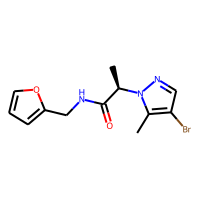
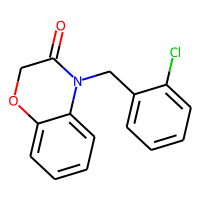
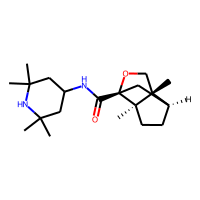
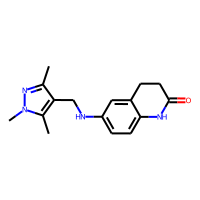
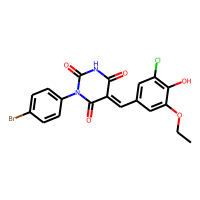

In [26]:
best_pop_at_0.head()

In [27]:
max_at_0 = best_pop_at_0['member'].nunique()
max_overall = best_pop_overall['member'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 10000
max overall: 10000
% improvement: 0.0
 improvement: 0


## target profile changes

#### number of targets

In [28]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)

duplicate_at_0 = targets_for_0.shape[0]

targets_for_0.drop_duplicates(inplace = True)

duplicate_at_0 = duplicate_at_0 - targets_for_0.shape[0]

print(targets_for_0.shape)

print(duplicate_at_0)
targets_for_0.head()

(16356, 1)
(1162, 1)
15194


targets
0  CHEMBL1293232
1  CHEMBL1293303
2     CHEMBL3622
3  CHEMBL3988596
4     CHEMBL6136

In [29]:
targets_for_best_overall = pd.DataFrame(best_pop_overall['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])

print(targets_for_best_overall.shape)
duplicate_overall = targets_for_best_overall.shape[0]

targets_for_best_overall.drop_duplicates(inplace = True)
duplicate_overall = duplicate_overall - targets_for_best_overall.shape[0]


print(targets_for_best_overall.shape)

print(duplicate_overall)

targets_for_best_overall.head()

(17783, 1)
(1459, 1)
16324


targets
0  CHEMBL1293248
1     CHEMBL2335
2  CHEMBL1287622
3     CHEMBL3356
4      CHEMBL205

In [30]:
duplicate_overall - duplicate_at_0

1130

In [31]:
max_at_0 = targets_for_0['targets'].nunique()
max_overall = targets_for_best_overall['targets'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 1162
max overall: 1459
% improvement: 25.559380378657487
 improvement: 297


#### number of pfams

In [32]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")

targets_for_best_overall = pd.merge(targets_for_best_overall, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")


In [33]:
targets_for_0.head()

targets target_chembl_id   clan     pfam  clan_novelty_score  \
0  CHEMBL1293232    CHEMBL1293232  c1757  PF06003            0.013047   
1  CHEMBL1293303    CHEMBL1293303  c1477  PF00600            1.000000   
2     CHEMBL3622       CHEMBL3622    c59  PF00067            0.342734   
3  CHEMBL3988596    CHEMBL3988596  c2619  PF01233            1.000000   
4     CHEMBL6136       CHEMBL6136  c2348  PF01593            1.000000   

   pfam_novelty_score  in_actives  in_predicted  
0            0.013047           1             1  
1            1.000000           1             1  
2            0.398705           1             1  
3            1.000000           1             1  
4            0.775915           1             1

In [34]:
print(targets_for_0.shape)
print(targets_for_best_overall.shape)

(1312, 8)
(1628, 8)


In [35]:


max_at_0 = targets_for_0['pfam'].nunique()
max_overall = targets_for_best_overall['pfam'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 486
max overall: 522
% improvement: 7.4074074074074066
 improvement: 36


### change in median novelty score

In [36]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
max_overall = targets_for_best_overall['pfam_novelty_score'].median()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 0.7502971093830421
max overall: 0.7502971093830421
% improvement: 0.0
 improvement: 0.0


# novel7_elitist_pfam_novelty_parallel_10k_1000_300_0randoms

## fitness score evolution

In [7]:
evolution_scores = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_10k_1000_300_0randoms/result_novel7_elitist_pfam_novelty_parallel_10k_1000_300_0randoms.csv",encoding='utf-8')

In [8]:
evolution_scores['use'] = evolution_scores['generation'] % 10 ==0

In [9]:
print(evolution_scores.shape)
evolution_scores.head()

(300000, 3)


fitness  generation   use
0  0.433772           0  True
1  0.436554           0  True
2  0.433282           0  True
3  0.438082           0  True
4  0.434191           0  True

In [10]:
evolution_scores.tail()

fitness  generation    use
299995  0.517825         299  False
299996  0.529530         299  False
299997  0.505722         299  False
299998  0.505805         299  False
299999  0.526881         299  False

In [11]:
plot_evolution_scores = evolution_scores[evolution_scores.use]
plot_evolution_scores.head()

fitness  generation   use
0  0.433772           0  True
1  0.436554           0  True
2  0.433282           0  True
3  0.438082           0  True
4  0.434191           0  True

Text(0, 0.5, 'fitness')

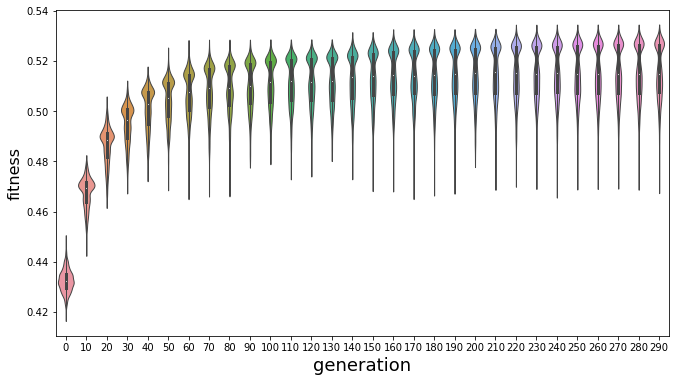

In [12]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))


ax = sns.violinplot(x="generation", y="fitness", data=plot_evolution_scores, bw=.2, cut=1, linewidth=1)

# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=16)


In [13]:
line_plot_evolution_scores = evolution_scores.groupby("generation")

line_plot_evolution_scores = line_plot_evolution_scores.max()

line_plot_evolution_scores = line_plot_evolution_scores.reset_index()

line_plot_evolution_scores.head()

generation   fitness    use
0           0  0.449723   True
1           1  0.451610  False
2           2  0.458323  False
3           3  0.465014  False
4           4  0.467228  False

<AxesSubplot:xlabel='generation', ylabel='fitness'>

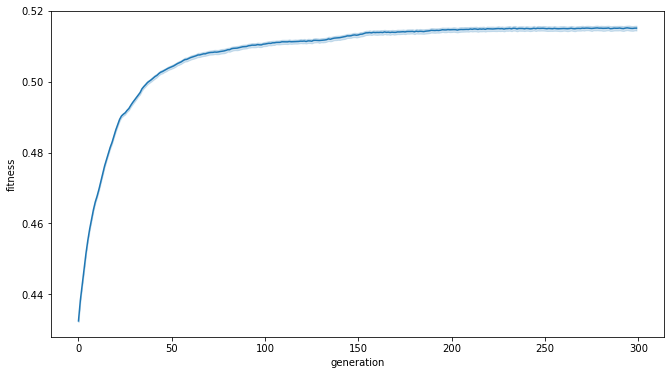

In [14]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=evolution_scores, x="generation", y="fitness")

(array([0.45, 0.5 , 0.55]), [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

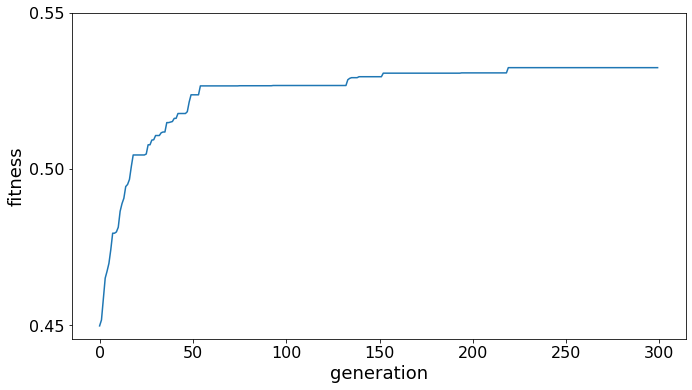

In [19]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(data=line_plot_evolution_scores, x="generation", y="fitness")
# Finalize the figure
plt.xlabel('generation', fontsize=18)
plt.ylabel('fitness', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(np.arange(0.45,0.55, .05))
plt.yticks(fontsize=16)

In [47]:
max_at_0 = evolution_scores[evolution_scores['generation']==0].fitness.max()
max_overall = evolution_scores.fitness.max()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("improvement:",((max_overall-max_at_0)/max_at_0)*100 )

max at 0: 0.44972343470549575
max overall: 0.5323869827176199
improvement: 18.380974090500054


## population scaffold change

In [48]:
best_pop_at_0 = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_10k_1000_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_10k_1000_300_0randoms_0.csv",encoding='utf-8',names=['file_index'])

In [49]:
best_pop_overall = pd.read_csv("Results/saga_results/novel7_elitist_pfam_novelty_parallel_10k_1000_300_0randoms/best_chromo_novel7_elitist_pfam_novelty_parallel_10k_1000_300_0randoms_219.csv",encoding='utf-8',names=['file_index'])

In [50]:
print(len(best_pop_at_0))
print(len(best_pop_overall))

10000
10000


In [51]:
best_pop_at_0 = pd.merge(best_pop_at_0, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_at_0.head()

file_index  query_index                                       query_smiles  \
0   1025051.0       785862                  CC=Cc1nnc(NC(=O)CCc2ccc(OC)cc2)s1   
1    725112.0       237382  Cc1ccc(C(=O)N2CC[C@@H]3CCCC[C@@H]3C2)cc1S(=O)(...   
2   1129144.0      2697502             O=C(CNC(=O)c1ccco1)OCc1cc(=O)n2ccsc2n1   
3     16016.0       271367          Cc1ccc(N2CCC(N3CCCC[C@H](N(C)C)C3)CC2)cc1   
4   1413191.0      2289548  CS(=O)(=O)c1ccc(-c2cccc(NS(=O)(=O)c3ccccc3C(F)...   

           targets  
0     {CHEMBL5567}  
1      {CHEMBL253}  
2     {CHEMBL2026}  
3  {CHEMBL1287623}  
4     {CHEMBL5567}

In [52]:
best_pop_overall = pd.merge(best_pop_overall, pool, how = 'left', left_on="file_index", right_index=True)
best_pop_overall.head()

file_index  query_index                                       query_smiles  \
0   1347177.0      2585108    O=C(Cc1cccc([N+](=O)[O-])c1)N1CCN(c2ccccc2O)CC1   
1    502680.0       850879  CC(C)(C)n1ccc(C(=O)N2CCC[C@H](c3ccc(C(=O)O)cc3...   
2     32499.0       335643                    Cc1ccc(Oc2nc3ccccc3n(C)c2=O)cc1   
3    148744.0      2358666              N#Cc1cccc(C(=O)N2CCN(c3ccccc3F)CC2)c1   
4    443308.0      1125614     C[C@@H](Cc1ccccc1)NC(=O)c1cccc([N+](=O)[O-])c1   

                                             targets  
0                                        {CHEMBL287}  
1                                    {CHEMBL1293303}  
2  {CHEMBL1293303,CHEMBL1293294,CHEMBL5567,CHEMBL...  
3                                    {CHEMBL1293238}  
4                                       {CHEMBL4158}

In [53]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_at_0,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_at_0, molCol='molecule', MurckoCol='murcko_smiles')

In [54]:
#add molecule
PandasTools.AddMoleculeColumnToFrame(best_pop_overall,'query_smiles','molecule')
    
#add scaffold
PandasTools.AddMurckoToFrame(best_pop_overall, molCol='molecule', MurckoCol='murcko_smiles')

In [55]:
max_at_0 = best_pop_at_0['murcko_smiles'].nunique()
max_overall = best_pop_overall['murcko_smiles'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 

max at 0: 7661
max overall: 7651
% improvement: -0.13053126223730582
 improvement: -10


## cluster representation change

In [56]:
best_pop_at_0 = pd.merge(best_pop_at_0, clusters,  how = 'left', left_on="query_index", right_on="member")
best_pop_overall = pd.merge(best_pop_overall, clusters,  how = 'left', left_on="query_index", right_on="member")

file_index  query_index                                       query_smiles  \
0   1025051.0       785862                  CC=Cc1nnc(NC(=O)CCc2ccc(OC)cc2)s1   
1    725112.0       237382  Cc1ccc(C(=O)N2CC[C@@H]3CCCC[C@@H]3C2)cc1S(=O)(...   
2   1129144.0      2697502             O=C(CNC(=O)c1ccco1)OCc1cc(=O)n2ccsc2n1   
3     16016.0       271367          Cc1ccc(N2CCC(N3CCCC[C@H](N(C)C)C3)CC2)cc1   
4   1413191.0      2289548  CS(=O)(=O)c1ccc(-c2cccc(NS(=O)(=O)c3ccccc3C(F)...   

           targets                                           molecule  \
0     {CHEMBL5567}  <img data-content="rdkit/molecule" src="data:i...   
1      {CHEMBL253}  <img data-content="rdkit/molecule" src="data:i...   
2     {CHEMBL2026}  <img data-content="rdkit/molecule" src="data:i...   
3  {CHEMBL1287623}  <img data-content="rdkit/molecule" src="data:i...   
4     {CHEMBL5567}  <img data-content="rdkit/molecule" src="data:i...   

                            murcko_smiles  cluster_id   member  
0                 O=C(CCc1ccccc1)Nc1nncs1      785862   785862  
1   O=C(c1ccccc1)N1CC[C@@H]2CCCC[C@@H]2C1      237382   237382  
2  O=C(CNC(=O)c1ccco1)OCc1cc(=O)n2ccsc2n1     2697502  2697502  
3           c1ccc(N2CCC(N3CCCCCC3)CC2)cc1      271367   271367  
4   O=S(=O)(Nc1cccc(-c2cccnn2)c1)c1ccccc1     2289548  2289548
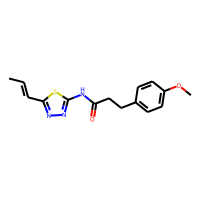
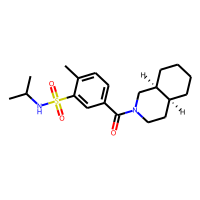
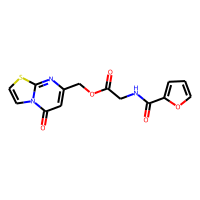
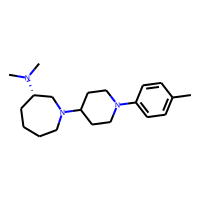
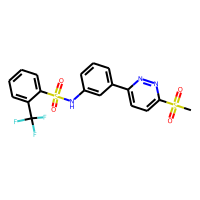

In [57]:
best_pop_at_0.head()

In [58]:
max_at_0 = best_pop_at_0['member'].nunique()
max_overall = best_pop_overall['member'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 10000
max overall: 10000
% improvement: 0.0
 improvement: 0


## target profile changes

#### number of targets

In [59]:
targets_for_0 = pd.DataFrame(best_pop_at_0['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])
print(targets_for_0.shape)

duplicate_at_0 = targets_for_0.shape[0]

targets_for_0.drop_duplicates(inplace = True)

duplicate_at_0 = duplicate_at_0 - targets_for_0.shape[0]

print(targets_for_0.shape)

print(duplicate_at_0)
targets_for_0.head()

(16661, 1)
(1263, 1)
15398


targets
0     CHEMBL5567
1      CHEMBL253
2     CHEMBL2026
3  CHEMBL1287623
5  CHEMBL1293294

In [60]:
targets_for_best_overall = pd.DataFrame(best_pop_overall['targets'].apply(lambda x: x.strip('{}').split(',')).apply(pd.Series).stack().values,
                              columns=['targets'])

print(targets_for_best_overall.shape)
duplicate_overall = targets_for_best_overall.shape[0]

targets_for_best_overall.drop_duplicates(inplace = True)
duplicate_overall = duplicate_overall - targets_for_best_overall.shape[0]


print(targets_for_best_overall.shape)

print(duplicate_overall)

targets_for_best_overall.head()

(18104, 1)
(1312, 1)
16792


targets
0      CHEMBL287
1  CHEMBL1293303
3  CHEMBL1293294
4     CHEMBL5567
5  CHEMBL1293277

In [61]:
duplicate_overall - duplicate_at_0

1394

In [62]:
max_at_0 = targets_for_0['targets'].nunique()
max_overall = targets_for_best_overall['targets'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 1263
max overall: 1312
% improvement: 3.879651623119557
 improvement: 49


#### number of pfams

In [63]:
targets_for_0 = pd.merge(targets_for_0, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")

targets_for_best_overall = pd.merge(targets_for_best_overall, targets_novelty_scores, how = 'left', left_on="targets", right_on="target_chembl_id")


In [64]:
targets_for_0.head()

targets target_chembl_id   clan     pfam  clan_novelty_score  \
0     CHEMBL5567       CHEMBL5567   c249  PF00501            0.926807   
1      CHEMBL253        CHEMBL253   c321  PF00001            0.724818   
2     CHEMBL2026       CHEMBL2026    c71  PF00144            0.883195   
3  CHEMBL1287623    CHEMBL1287623  c2562  PF02820            1.000000   
4  CHEMBL1293294    CHEMBL1293294  c1464  PF00071            1.000000   

   pfam_novelty_score  in_actives  in_predicted  
0            0.917624           1             1  
1            0.474948           1             1  
2            0.927981           1             1  
3            1.000000           1             1  
4            0.995925           1             1

In [65]:
print(targets_for_0.shape)
print(targets_for_best_overall.shape)

(1444, 8)
(1466, 8)


In [66]:


max_at_0 = targets_for_0['pfam'].nunique()
max_overall = targets_for_best_overall['pfam'].nunique()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 493
max overall: 513
% improvement: 4.056795131845842
 improvement: 20


### change in median novelty score

In [67]:
max_at_0 = targets_for_0['pfam_novelty_score'].median()
max_overall = targets_for_best_overall['pfam_novelty_score'].median()


print("max at 0:",max_at_0)
print("max overall:",max_overall)
print("% improvement:",((max_overall-max_at_0)/max_at_0)*100 )
print(" improvement:",(max_overall-max_at_0) ) 


max at 0: 0.7198050817960321
max overall: 0.7502971093830421
% improvement: 4.2361506410773515
 improvement: 0.030492027587009973
